In [1]:
from seligator.common.params import MetadataEncoding, Seq2VecEncoderType, BasisVectorConfiguration
from seligator.main import train_and_get, Seligator
from seligator.common.load_save import load
from seligator.tests.evaluate import run_tests

from seligator.models.siamese import SiameseClassifier
from seligator.models.classifier import FeatureEmbeddingClassifier
import os
import json
import logging

logger = logging.getLogger()
logger.setLevel(logging.WARNING)

def get_json_fn(fn):
    return f"results-{fn}.json"

def already_done(fn):
    return os.path.exists(get_json_fn(fn))

def save_json(fn, obj):
    with open(get_json_fn(fn), "w") as f:
        json.dump(obj, f)


# Run tests on Vectors Categories
def get_kwargs():
    METADATA_CATS = ("Century", "Textgroup", "WrittenType", "CitationTypes")
    BVC = BasisVectorConfiguration(
        categories=METADATA_CATS
    )
    return dict(
        token_features=("lemma_char", "lemma")
        msd_features=("case", "numb", "gend", "mood", "tense", "voice", "person", "deg"),
        seq2vec_encoder_type=Seq2VecEncoderType.LSTM,
        basis_vector_configuration=BVC,
        agglomerate_msd=False,
        reader_kwargs={
            "batch_size": 4, 
            "metadata_encoding": MetadataEncoding.IGNORE,
            "metadata_tokens_categories": METADATA_CATS
        },
        model_embedding_kwargs=dict(
            keep_all_vocab=True,
            pretrained_embeddings={
                # "token": "~/Downloads/latin.embeddings",
            #    "token": "~/dev/these/notebooks/4 - Detection/data/embs_models/model.token.word2vec.kv",
            #    "lemma": "~/dev/these/notebooks/4 - Detection/data/embs_models/model.lemma.word2vec.kv.header"
            },
            trainable_embeddings={"token": False, "lemma": False},
            emb_dims={"token": 200, "lemma": 200}
        ),
        encoder_hidden_size=64,
        batches_per_epoch=None,
        model_class=FeatureEmbeddingClassifier,
        use_bert_highway=False,
        bert_dir: str = "./bert/latin_bert",
    )

    # 
#        additional_model_kwargs={
#            "metadata_linear": False,
#        }
    
def get_train_and_get_kwargs():
    return dict(patience=4, num_epochs=20, lr=5e-4, optimizer="AdamW")

def jqs(data):
    return "-".join(sorted(list(data)))

def get_filename(params, prefix = "model"):
    remaped = []
    for key in sorted(list(params.keys())):
        if isinstance(params[key], str) and not params[key]:
            continue
        if isinstance(params[key], str) and "-" in params[key]:
            remaped.append(f"{key}-"+"".join([
                "".join([
                    subv[:3].lower().capitalize()
                    for subv in v.split("_")
                ])
                for v in params[key].split("-")
            ]))
        else:
            remaped.append(f"{key}-{params[key]}")
    print(remaped)
    return prefix+"--"+"__".join(remaped)

def merge(source, destination):
    """ Source = New , Destination = Default
    run me with nosetests --with-doctest file.py

    >>> a = { 'first' : { 'all_rows' : { 'pass' : 'dog', 'number' : '1' } } }
    >>> b = { 'first' : { 'all_rows' : { 'fail' : 'cat', 'number' : '5' } } }
    >>> merge(b, a) == { 'first' : { 'all_rows' : { 'pass' : 'dog', 'fail' : 'cat', 'number' : '5' } } }
    True
    """
    for key, value in source.items():
        if isinstance(value, dict):
            # get node or create one
            node = destination.setdefault(key, {})
            merge(value, node)
        else:
            destination[key] = value

    return destination

def run_and_save(prepare_model_kwargs, train_kwargs, model_name_prefix: str = "model"):
    main_params = {
        "Features": jqs(prepare_model_kwargs["input_features"]),
        "Metadata": jqs(prepare_model_kwargs["reader_kwargs"]["metadata_tokens_categories"]),
        "MetadataEncoding": prepare_model_kwargs["reader_kwargs"]["metadata_encoding"].name,
        "Pretrain": jqs(prepare_model_kwargs["model_embedding_kwargs"]["pretrained_embeddings"].keys()),
        "Trainable": jqs([
            key 
            for key in prepare_model_kwargs["model_embedding_kwargs"]["trainable_embeddings"]
            if key in prepare_model_kwargs["model_embedding_kwargs"]["pretrained_embeddings"] and
            prepare_model_kwargs["model_embedding_kwargs"]["trainable_embeddings"][key] is True
        ]),
        "AgglomerateMSD": prepare_model_kwargs["agglomerate_msd"],
        "Encoder": prepare_model_kwargs["seq2vec_encoder_type"].name,
        **prepare_model_kwargs.get("additional_model_kwargs", {}),
        "Model": prepare_model_kwargs["model_class"].__name__.replace("Classifier", "")
    }
    if "token_subword" in prepare_model_kwargs["input_features"]:
        main_params["Highway"] = prepare_model_kwargs.get("use_bert_highway", False)
        
    if main_params["Model"] == "Siamese":
        main_params["BpE"] = prepare_model_kwargs.get("batches_per_epoch", None)
        
    fn = get_filename(main_params, model_name_prefix)
    
    if already_done(fn):
        print(f"Already trained {fn}")
        return {}
    
    seligator, reader, train, dev = Seligator.init_for_training_with_params(**prepare_model_kwargs)
    _ = train_and_get(seligator.model, train, dev, **train_kwargs)
    data, img = run_tests(
        "dataset/split/test.txt",
        dataset_reader=reader, model=seligator.model, dump=f"test.{fn}.csv"
    )
    out = {
        fn: {
            **{x:v for x, v in data.items() if isinstance(v, float)},
            **main_params,
            **train_kwargs
        }
    }
    save_json(fn, out)
    return out

def get_siamese():
    siamese = get_kwargs()
    siamese["model_class"] = SiameseClassifier
    siamese["batches_per_epoch"] = 20
    siamese_train_kwargs = get_train_and_get_kwargs()
    siamese_train_kwargs["num_epochs"] = siamese_train_kwargs["num_epochs"] * int(1351 // siamese["batches_per_epoch"])
    siamese_train_kwargs["patience"] = 10
    return siamese, siamese_train_kwargs

def get_classic():
    return get_kwargs(), get_train_and_get_kwargs()

RUNS = {}

2021-07-31 13:41:21.923899: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [5]:
# Check what can be JSONIFIED

import json

# https://stackoverflow.com/questions/24481852/serialising-an-enum-member-to-json

class CustomEncoder(json.JSONEncoder):
    _PUBLIC_ENUMS = {
        "MetadataEncoding": MetadataEncoding, 
        "Seq2VecEncoderType": Seq2VecEncoderType, 
        #"BasisVectorConfiguration": BasisVectorConfiguration
    }
    _PUBLIC_CLASSES = {
        "SiameseClassifier": SiameseClassifier,
        "FeatureEmbeddingClassifier": FeatureEmbeddingClassifier
    }

    def default(self, obj):
        if type(obj) in CustomEncoder._PUBLIC_ENUMS.values():
            return {"__enum__": str(obj)}
        elif isinstance(obj, type):
            if obj in CustomEncoder._PUBLIC_CLASSES.values():
                return {"__type__": str(obj.__name__)}
            else:
                print(obj)
        elif isinstance(obj, BasisVectorConfiguration):
            return {"__basis_vector_configuration__": obj.to_dict()}
        return json.JSONEncoder.default(self, obj)

    @staticmethod
    def object_hook(d):
        if "__enum__" in d:
            name, member = d["__enum__"].split(".")
            return getattr(CustomEncoder._PUBLIC_ENUMS[name], member)
        elif "__type__" in d:
            return CustomEncoder._PUBLIC_CLASSES[d["__type__"]]
        elif "__basis_vector_configuration__" in d:
            return BasisVectorConfiguration.from_dict(d["__basis_vector_configuration__"])
        else:
            return d


PRE_LEMMA = {
    "model_embedding_kwargs":{
        "pretrained_embeddings": {
            "lemma": "~/dev/these/notebooks/4 - Detection/data/embs_models/model.lemma.word2vec.kv.header"
        }
    }
}
json.dumps(merge({"agglomerate_msd": True, "seq2vec_encoder_type": Seq2VecEncoderType.HAN,
                "reader_kwargs": {"metadata_encoding": MetadataEncoding.AS_CATEGORICAL},
                "additional_model_kwargs": { "metadata_linear": True},
                **PRE_LEMMA
            }, get_kwargs()), cls=CustomEncoder)

'{"input_features": ["lemma_char", "lemma", "case", "numb", "gend", "mood", "tense", "voice", "person", "deg"], "seq2vec_encoder_type": {"__enum__": "Seq2VecEncoderType.HAN"}, "basis_vector_configuration": {"__basis_vector_configuration__": {"categories": ["Century", "Textgroup", "WrittenType", "CitationTypes"], "categories_dim": null, "emb_dim": 64, "num_bases": 3, "key_query_size": 64}}, "agglomerate_msd": true, "reader_kwargs": {"batch_size": 4, "metadata_encoding": {"__enum__": "MetadataEncoding.AS_CATEGORICAL"}, "metadata_tokens_categories": ["Century", "Textgroup", "WrittenType", "CitationTypes"]}, "model_embedding_kwargs": {"keep_all_vocab": true, "pretrained_embeddings": {"lemma": "~/dev/these/notebooks/4 - Detection/data/embs_models/model.lemma.word2vec.kv.header"}, "trainable_embeddings": {"token": false, "lemma": false}, "pretrained_emb_dims": {"token": 200, "lemma": 200}}, "model_class": {"__type__": "FeatureEmbeddingClassifier"}, "use_bert_highway": false, "additional_mode

In [2]:
def do_runs(get_kw, has_linear=False):
    PRE_LEMMA = {
        "model_embedding_kwargs":{
            "pretrained_embeddings": {
                "lemma": "~/dev/these/notebooks/4 - Detection/data/embs_models/model.lemma.word2vec.kv.header"
            }
        }
    }
    Changes = [
        # Use raw Bert
        ({"input_features": ("token_subword", )}, {}),
        # Use raw Bert No Highway
        ({"input_features": ("token_subword", ), "use_bert_highway": True}, {}),
        # Use raw Bert + Lemma
        ({
            "input_features": ("token_subword", "lemma", "lemma_char"),
            "seq2vec_encoder_type": Seq2VecEncoderType.HAN,
            "use_bert_highway": False
        }, {}),
        ({}, {}),
        # Raw Features + MSD + Vanilla LSTM
        ({"agglomerate_msd": True}, {}),
        # Raw Features + MSD + HAN
        ({"agglomerate_msd": True, "seq2vec_encoder_type": Seq2VecEncoderType.HAN}, {}),
        # Raw Features + MSD + Enriched LSTM
        ({"agglomerate_msd": True, "seq2vec_encoder_type": Seq2VecEncoderType.MetadataLSTM,
            "reader_kwargs": {"metadata_encoding": MetadataEncoding.AS_CATEGORICAL}}, {}),
        # Raw Features + MSD + Enriched Attention
        ({"agglomerate_msd": True, "seq2vec_encoder_type": Seq2VecEncoderType.MetadataAttentionPooling,
            "reader_kwargs": {"metadata_encoding": MetadataEncoding.AS_CATEGORICAL}}, {}),
        # Raw Features + MSD + Attention
        ({"agglomerate_msd": True, "seq2vec_encoder_type": Seq2VecEncoderType.AttentionPooling,
            "reader_kwargs": {"metadata_encoding": MetadataEncoding.AS_CATEGORICAL}}, {}),
        # Now we use Metadata Tokens !
        # Raw Features + MSD + Attention
        #({ # Does not work because AttentionPooling expects metadata_vector
        #    "reader_kwargs": {"metadata_encoding": MetadataEncoding.AS_TOKEN},
        #    "agglomerate_msd": True, "seq2vec_encoder_type": Seq2VecEncoderType.AttentionPooling}, {}),
        # Raw Features + MSD + Attention
        ({
            "reader_kwargs": {"metadata_encoding": MetadataEncoding.AS_TOKEN},
            "agglomerate_msd": True, "seq2vec_encoder_type": Seq2VecEncoderType.HAN}, {}),
        #
        #
        # With Pretrained
        #
        #
        # Raw Features + MSD + Vanilla LSTM
        ({"agglomerate_msd": True, **PRE_LEMMA}, {}),
        # Raw Features + MSD + HAN
        ({"agglomerate_msd": True, "seq2vec_encoder_type": Seq2VecEncoderType.HAN,
          **PRE_LEMMA}, {}),
        # Raw Features + MSD + Enriched LSTM
        ({"agglomerate_msd": True, "seq2vec_encoder_type": Seq2VecEncoderType.MetadataLSTM,
            "reader_kwargs": {"metadata_encoding": MetadataEncoding.AS_CATEGORICAL},
          **PRE_LEMMA}, {}),
        # Raw Features + MSD + Enriched Attention
        ({"agglomerate_msd": True, "seq2vec_encoder_type": Seq2VecEncoderType.MetadataAttentionPooling,
            "reader_kwargs": {"metadata_encoding": MetadataEncoding.AS_CATEGORICAL},
          **PRE_LEMMA}, {}),
        # Raw Features + MSD + Attention
        ({"agglomerate_msd": True, "seq2vec_encoder_type": Seq2VecEncoderType.AttentionPooling,
            "reader_kwargs": {"metadata_encoding": MetadataEncoding.AS_CATEGORICAL},
          **PRE_LEMMA}, {}),
    ]
    if has_linear:
        Changes = Changes + [
            ({
                "reader_kwargs": {"metadata_encoding": MetadataEncoding.AS_CATEGORICAL},
                "additional_model_kwargs": { "metadata_linear": True}
            }, {}),
            ({
                "reader_kwargs": {"metadata_encoding": MetadataEncoding.AS_CATEGORICAL},
                "additional_model_kwargs": { "metadata_linear": True},
                **PRE_LEMMA
            }, {}),
            ({"agglomerate_msd": True, "seq2vec_encoder_type": Seq2VecEncoderType.HAN,
                "reader_kwargs": {"metadata_encoding": MetadataEncoding.AS_CATEGORICAL},
                "additional_model_kwargs": { "metadata_linear": True},
                **PRE_LEMMA
            }, {}),
            ({"agglomerate_msd": True, "seq2vec_encoder_type": Seq2VecEncoderType.MetadataLSTM,
                "reader_kwargs": {"metadata_encoding": MetadataEncoding.AS_CATEGORICAL},
                "additional_model_kwargs": { "metadata_linear": True},
                **PRE_LEMMA
            }, {}),
            # Apparently, its the best, so let's play with input features
            # ("lemma_char", "lemma", "case", "numb", "gend", "mood", "tense", "voice", "person", "deg")
            ({"input_features": ("lemma_char", "lemma"), #No morph
              "agglomerate_msd": False, "seq2vec_encoder_type": Seq2VecEncoderType.HAN,
                "reader_kwargs": {"metadata_encoding": MetadataEncoding.AS_CATEGORICAL},
                "additional_model_kwargs": { "metadata_linear": True},
                **PRE_LEMMA
            }, {}), # No chars
            ({"input_features": ("lemma", "case", "numb", "gend", "mood", "tense", "voice", "person", "deg"), #No morph
              "agglomerate_msd": False, "seq2vec_encoder_type": Seq2VecEncoderType.HAN,
                "reader_kwargs": {"metadata_encoding": MetadataEncoding.AS_CATEGORICAL},
                "additional_model_kwargs": { "metadata_linear": True},
                **PRE_LEMMA
            }, {}), # No chars but tokens
            ({"input_features": ("lemma", "token", "case", "numb", "gend", "mood", "tense", "voice", "person", "deg"), #No morph
              "agglomerate_msd": False, "seq2vec_encoder_type": Seq2VecEncoderType.HAN,
                "reader_kwargs": {"metadata_encoding": MetadataEncoding.AS_CATEGORICAL},
                "additional_model_kwargs": { "metadata_linear": True},
                **PRE_LEMMA
            }, {}),
        ]
    for idx, (model_kw, train_kw) in enumerate(Changes):
        defaults_model, default_trains = get_kw()
        model_kw = merge(model_kw, defaults_model)
        train_kw = merge(train_kw, default_trains)
        RUNS.update(run_and_save(model_kw, train_kw, model_name_prefix=f"model{idx}-"))

# Siamese Networks

/home/thibault/dev/est-lascivuum-non-est/env/lib/python3.8/site-packages/allennlp/data/token_indexers/token_characters_indexer.py:55: UserWarning: You are using the default value (0) of `min_padding_length`, which can cause some subtle bugs (more info see https://github.com/allenai/allennlp/issues/1954). Strongly recommend to set a value, usually the maximum size of the convolutional layer size when using CnnEncoder.
  warnings.warn(


['AgglomerateMSD-False', 'Encoder-LSTM', 'Features-token_subword', 'Highway-False', 'Metadata-CenCitTexWri', 'MetadataEncoding-IGNORE', 'Model-FeatureEmbedding']
Already trained model0---AgglomerateMSD-False__Encoder-LSTM__Features-token_subword__Highway-False__Metadata-CenCitTexWri__MetadataEncoding-IGNORE__Model-FeatureEmbedding
['AgglomerateMSD-False', 'Encoder-LSTM', 'Features-token_subword', 'Highway-True', 'Metadata-CenCitTexWri', 'MetadataEncoding-IGNORE', 'Model-FeatureEmbedding']
Already trained model1---AgglomerateMSD-False__Encoder-LSTM__Features-token_subword__Highway-True__Metadata-CenCitTexWri__MetadataEncoding-IGNORE__Model-FeatureEmbedding
['AgglomerateMSD-False', 'Encoder-HAN', 'Features-LemLemChaTokSub', 'Highway-False', 'Metadata-CenCitTexWri', 'MetadataEncoding-IGNORE', 'Model-FeatureEmbedding']
Already trained model2---AgglomerateMSD-False__Encoder-HAN__Features-LemLemChaTokSub__Highway-False__Metadata-CenCitTexWri__MetadataEncoding-IGNORE__Model-FeatureEmbedding
[

building vocab:   0%|          | 0/5427 [00:00<?, ?it/s]

  0%|          | 0/155131 [00:00<?, ?it/s]

/home/thibault/dev/est-lascivuum-non-est/env/lib/python3.8/site-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


---> Epochs:   20
---> Patience: 4


  0%|          | 0/1357 [00:00<?, ?it/s]

/home/thibault/dev/est-lascivuum-non-est/seligator/models/classifier.py:59: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(logits)


  0%|          | 0/170 [00:00<?, ?it/s]

  0%|          | 0/1357 [00:00<?, ?it/s]

  0%|          | 0/170 [00:00<?, ?it/s]

  0%|          | 0/1357 [00:00<?, ?it/s]

  0%|          | 0/170 [00:00<?, ?it/s]

  0%|          | 0/1357 [00:00<?, ?it/s]

  0%|          | 0/170 [00:00<?, ?it/s]

  0%|          | 0/1357 [00:00<?, ?it/s]

  0%|          | 0/170 [00:00<?, ?it/s]

  0%|          | 0/1357 [00:00<?, ?it/s]

  0%|          | 0/170 [00:00<?, ?it/s]

  0%|          | 0/1357 [00:00<?, ?it/s]

  0%|          | 0/170 [00:00<?, ?it/s]

  0%|          | 0/1357 [00:00<?, ?it/s]

  0%|          | 0/170 [00:00<?, ?it/s]

  0%|          | 0/1357 [00:00<?, ?it/s]

  0%|          | 0/170 [00:00<?, ?it/s]

Evaluating


0it [00:00, ?it/s]

Evaluating: Predicting


/home/thibault/dev/est-lascivuum-non-est/seligator/tests/evaluate.py:111: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  disp.figure_.show()
/home/thibault/dev/est-lascivuum-non-est/env/lib/python3.8/site-packages/allennlp/data/token_indexers/token_characters_indexer.py:55: UserWarning: You are using the default value (0) of `min_padding_length`, which can cause some subtle bugs (more info see https://github.com/allenai/allennlp/issues/1954). Strongly recommend to set a value, usually the maximum size of the convolutional layer size when using CnnEncoder.
  warnings.warn(


['AgglomerateMSD-True', 'Encoder-MetadataLSTM', 'Features-CasDegGenLemLemChaMooNumPerTenVoi', 'Metadata-CenCitTexWri', 'MetadataEncoding-AS_CATEGORICAL', 'Model-FeatureEmbedding', 'Pretrain-lemma', 'metadata_linear-True']


building vocab:   0%|          | 0/5427 [00:00<?, ?it/s]

  0%|          | 0/155131 [00:00<?, ?it/s]

---> Epochs:   20
---> Patience: 4


  0%|          | 0/1357 [00:00<?, ?it/s]

/home/thibault/dev/est-lascivuum-non-est/seligator/models/classifier.py:59: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(logits)


  0%|          | 0/170 [00:00<?, ?it/s]

  0%|          | 0/1357 [00:00<?, ?it/s]

  0%|          | 0/170 [00:00<?, ?it/s]

  0%|          | 0/1357 [00:00<?, ?it/s]

  0%|          | 0/170 [00:00<?, ?it/s]

  0%|          | 0/1357 [00:00<?, ?it/s]

  0%|          | 0/170 [00:00<?, ?it/s]

  0%|          | 0/1357 [00:00<?, ?it/s]

  0%|          | 0/170 [00:00<?, ?it/s]

  0%|          | 0/1357 [00:00<?, ?it/s]

  0%|          | 0/170 [00:00<?, ?it/s]

Evaluating


0it [00:00, ?it/s]

Evaluating: Predicting


/home/thibault/dev/est-lascivuum-non-est/seligator/tests/evaluate.py:111: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  disp.figure_.show()


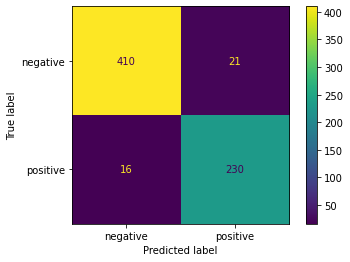

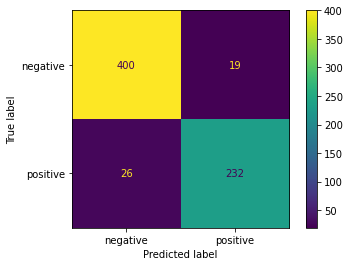

In [3]:
do_runs(get_classic, has_linear=True)

In [4]:
import glob
RUNS = []
for file in glob.glob("*.json"):
    with open(file) as f:
        RUNS.append(json.load(f))

In [9]:
best, best_key = 0, None
sorts = sorted([(list(run.keys())[0], list(run.values())[0]["accuracy"]) for run in RUNS], key=lambda x: x[1])
for key in sorts:
    print(key[0], key[1])

model4---AgglomerateMSD-True__Encoder-LSTM__Features-CasDegGenLemLemChaMooNumPerTenVoi__Metadata-CenCitTexWri__MetadataEncoding-IGNORE__Model-FeatureEmbedding 0.8493353028064993
model3---AgglomerateMSD-False__Encoder-LSTM__Features-CasDegGenLemLemChaMooNumPerTenVoi__Metadata-CenCitTexWri__MetadataEncoding-IGNORE__Model-FeatureEmbedding 0.8611521418020679
model7---AgglomerateMSD-True__Encoder-MetadataAttentionPooling__Features-CasDegGenLemLemChaMooNumPerTenVoi__Metadata-CenCitTexWri__MetadataEncoding-AS_CATEGORICAL__Model-FeatureEmbedding 0.8788774002954209
model0---AgglomerateMSD-False__Encoder-LSTM__Features-token_subword__Highway-False__Metadata-CenCitTexWri__MetadataEncoding-IGNORE__Model-FeatureEmbedding 0.8833087149187593
model11---AgglomerateMSD-True__Encoder-HAN__Features-CasDegGenLemLemChaMooNumPerTenVoi__Metadata-CenCitTexWri__MetadataEncoding-IGNORE__Model-FeatureEmbedding__Pretrain-lemma 0.8862629246676514
model5---AgglomerateMSD-True__Encoder-HAN__Features-CasDegGenLemLemCh